In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bdtcode.histogramming as H
import glob
import mplhep as hep

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
def err(value, bins, w):
    n=0
    val_var_err_square={}
    val_var_err_sumsquare={}
    val_var_err={}

    for i in range(0,len(value)):
        for j in range(0, len(value[i])):
            val_var_err_square[n] = np.histogram(value[i][j], bins=bins, weights=(w[i][j])**2)[0]
            n+=1
    for l in range(1,n+1):
        if l>26: continue
        val_var_err_sumsquare = np.add(val_var_err_square[l-1],val_var_err_square[l]) 
    val_var_err = np.sqrt(val_var_err_sumsquare)
    return val_var_err

def error_ratio(data,mc,err_data,err_mc):
    dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc
    return dA

def stacked_edge(value, bins, weight, data=True):
    val_var  = {}
    edges_var  = {}
    patches_var  = {}
    var_stacked = {}

    if data==True:  
        val_var, edges_var, patches_var = plt.hist(value, bins, stacked=True)
        var_stacked = val_var[len(val_var)-1]
        var_centre  = (edges_var[1:]+edges_var[:-1])/2
        var_edge = edges_var
    if data==False: 
        for i in range(0,len(value)):
            val_var[i], edges_var[i], patches_var[i] = plt.hist(value[i], bins, stacked=True, weights = weight[i])
        var_centre  = (edges_var[0][1:]+edges_var[0][:-1])/2
        var_stacked = val_var[0][len(val_var[0])-1] + val_var[1][len(val_var[1])-1] + val_var[2][len(val_var[2])-1] + val_var[3][len(val_var[3])-1]
        var_edge = edges_var[0]
    plt.close()
    return var_centre, var_stacked, var_edge




In [5]:
# This npz files are made by running npz_saver.ipynb code
# the original npz files have these selection cuts:
#  1- RTx < 1.15 
#  2- no lepton veto --> the veto is added manually; the presence is affecting ttjets 
#                         and wjets by --- %

In [6]:
# Loading MC npz files

#qcd_bin = (list(np.load('npzfiles/qcd_bin'+str(n) +'.npz') for n in range(0,9)))
qcd_bin = (list(np.load('qcd_bin'+str(n) +'.npz') for n in range(0,9)))
ttjet_bin = (list(np.load('npzfiles/ttjet_bin'+str(n) +'.npz') for n in range(0,8)))
wjet_bin  = (list(np.load('npzfiles/wjet_bin'+str(n) +'.npz') for n in range(0,5)))
zjet_bin  = (list(np.load('npzfiles/zjet_bin'+str(n) +'.npz') for n in range(0,5)))


# Loading data_prehem npz files
data_prehem = (list(np.load('npzfiles/data_prehem_run'+str(n) +'.npz') for n in ('A','B')))

In [7]:
# Computing weights
# Computing MC weights:
#  1-preselection efficiencies 

qcd_sel_eff  = (list(len(qcd_bin[n]['pt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)])/qcd_bin[n]['total'] for n in range(0,9)))
ttjet_sel_eff  = (list(len(ttjet_bin[n]['pt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)])/ttjet_bin[n]['total'] for n in range(0,8)))
wjet_sel_eff  = (list(len(wjet_bin[n]['pt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)])/wjet_bin[n]['total'] for n in range(0,5)))
zjet_sel_eff  = (list(len(zjet_bin[n]['pt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)])/zjet_bin[n]['total'] for n in range(0,5)))


#  2-number of events passing from preselection efficiencies
qcd_pass   = (list(qcd_bin[n]['preselection'] for n in range(0,9)))
ttjet_pass = (list(ttjet_bin[n]['preselection'] for n in range(0,8)))
wjet_pass  = (list(wjet_bin[n]['preselection'] for n in range(0,5)))
zjet_pass  = (list(zjet_bin[n]['preselection'] for n in range(0,5)))

#  3-Compute data_prehem luminosity to weight MC
#    lumi runA + runB ( from https://twiki.cern.ch/twiki/bin/viewauth/CMS/
#    RA2b13TeVProduction#Dataset_luminosities_2018_pb_1)
prehem_lumi = 14026.948 + 7044.413 

#  5-MC XSec
qcd_crossections = np.array([7823, 648, 186.9, 32.293, 9.4183, 0.84265, 0.114943, 0.00682981, 0.000165445])#reference: SVJ AN note
ttjet_crossections = np.array([88.34, 182.72, 182.72, 831.76, 2.685, 1.096, 0.194, 0.002]) #reference: https://github.com/boostedsvj/svj-bdt/blob/merged/bdtcode/crosssections.py
zjet_crossections = np.array([9.921*1.1347, 2.409*1.1347, 1.078*1.1347, 0.2514*1.1347, 0.005614*1.1347])#reference: https://github.com/boostedsvj/svj-bdt/blob/merged/bdtcode/crosssections.py
wjet_crossections = np.array([45.25*1.139, 10.97*1.139, 4.933*1.139, 1.16*1.139, 0.02627*1.139])#reference: https://github.com/boostedsvj/svj-bdt/blob/merged/bdtcode/crosssections.py

#  6-Compute weight
qcd_weight    = qcd_crossections   *qcd_sel_eff    * prehem_lumi / qcd_pass
ttjet_weight  = ttjet_crossections *ttjet_sel_eff  * prehem_lumi / ttjet_pass
wjet_weight   = wjet_crossections  *wjet_sel_eff   * prehem_lumi / wjet_pass
zjet_weight   = zjet_crossections  *zjet_sel_eff   * prehem_lumi / zjet_pass


# data_prehem weights is equal to one
# number of events of runA, B should be added together
#***********************************************************************************************
# add all MC (qcd, ttjets, wjets, zjets) npz files in one big array --> mc_pt_values
# mc_pt_values array has 4 elements, and each elements has several bins
# mc_weights_arr is the weight that should be applied on histogramming

labels_qcd=['PT300to470','PT470to600','PT600to800','PT800to1000', 'PT1000to1400', 'PT1400to1800', 'PT1800to2400', 'PT2400to3200', 'PT3200toInf']
labels_ttjet=['DiLept', 'SingleLeptFromTbar', 'SingleLeptFromT', 'TuneCP5', 'HT-600To800','HT-800To1200','HT-1200To2500', 'HT-2500ToInf']
labels_wjet=['HT-400To600','HT-600To800','HT-800To1200','HT-1200To2500', 'HT-2500ToInf']
labels_zjet=['HT-400To600','HT-600To800','HT-800To1200','HT-1200To2500', 'HT-2500ToInf']

qcd_label    = [labels_qcd[n] for n in range(0,9)]
ttjet_label  = [labels_ttjet[n] for n in range(0,8)]
wjet_label   = [labels_wjet[n] for n in range(0,5)]
zjet_label   = [labels_zjet[n] for n in range(0,5)]

qcd_pt_values  = [qcd_bin[n]['pt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_pt_values  = [ttjet_bin[n]['pt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_pt_values  =  [wjet_bin[n]['pt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_pt_values  =  [zjet_bin[n]['pt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]

qcd_weights_arr    = [np.ones_like(qcd_bin[n]['pt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)])*qcd_weight[n] for n in range(0,9)]
ttjet_weights_arr  = [np.ones_like(ttjet_bin[n]['pt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)])*ttjet_weight[n] for n in range(0,8)]
wjet_weights_arr   = [np.ones_like(wjet_bin[n]['pt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)])*wjet_weight[n] for n in range(0,5)]
zjet_weights_arr   = [np.ones_like(zjet_bin[n]['pt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)])*zjet_weight[n] for n in range(0,5)]



mc_pt_values  = [qcd_pt_values , ttjet_pt_values , wjet_pt_values , zjet_pt_values ]
mc_labels = [qcd_label, ttjet_label, wjet_label, zjet_label]
mc_weights_arr  = [qcd_weights_arr , ttjet_weights_arr , wjet_weights_arr , zjet_weights_arr ]


data_pt_values  =   [data_prehem[n]['pt'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]
data_weight_arr = [np.ones_like(data_pt_values[0]), np.ones_like(data_pt_values[1])]


In [6]:
# ratio plots of the sub-leading jets

/tmp/ipykernel_29295/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

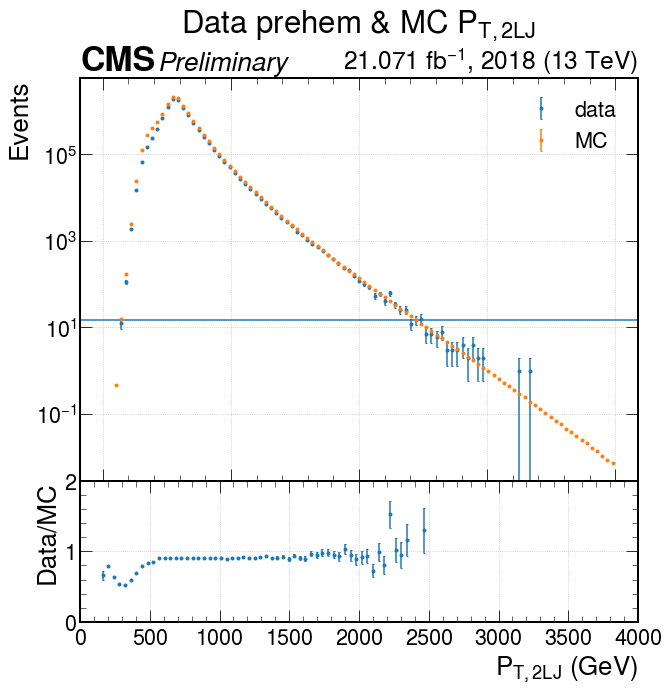

In [164]:
# define variables array
# MC each source array
qcd_pt_values  = [qcd_bin[n]['pt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_pt_values  = [ttjet_bin[n]['pt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_pt_values  =  [wjet_bin[n]['pt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_pt_values  =  [zjet_bin[n]['pt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_pt_values  = [qcd_pt_values , ttjet_pt_values , wjet_pt_values , zjet_pt_values ]
# data variable array
data_pt_values  =   [data_prehem[n]['pt'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
pt_bins = np.linspace(0, 4000, 100)
data_pt_centre, data_pt_stacked, data_edges_pt = stacked_edge(data_pt_values, pt_bins, data_weight_arr, True)
data_pt_err = np.sqrt(data_pt_stacked)

mc_pt_centre, mc_pt_stacked, mc_edges_pt = stacked_edge(mc_pt_values, pt_bins, mc_weights_arr, False)
mc_pt_err = err(mc_pt_values, pt_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_pt_centre, y=data_pt_stacked, yerr=data_pt_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_pt_centre,   y=mc_pt_stacked,   yerr=mc_pt_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $P_{T,2LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_pt_stacked,
                  mc_pt_stacked,
                  where=(mc_pt_stacked != 0))
                  
rotio = ratio[(mc_pt_stacked!=0) & (data_pt_stacked>15)]
edges = data_edges_pt[:len(data_edges_pt)-1][(mc_pt_stacked!=0) & (data_pt_stacked>15)]
ratio_err = error_ratio(data_pt_stacked, mc_pt_stacked, np.sqrt(data_pt_stacked), mc_pt_err)
rotio_err = ratio_err[(mc_pt_stacked!=0) & (data_pt_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$P_{T,2LJ}$ (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,4000)
fig.savefig('png/PT2LJ_RatioPlot.png')

/tmp/ipykernel_29295/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

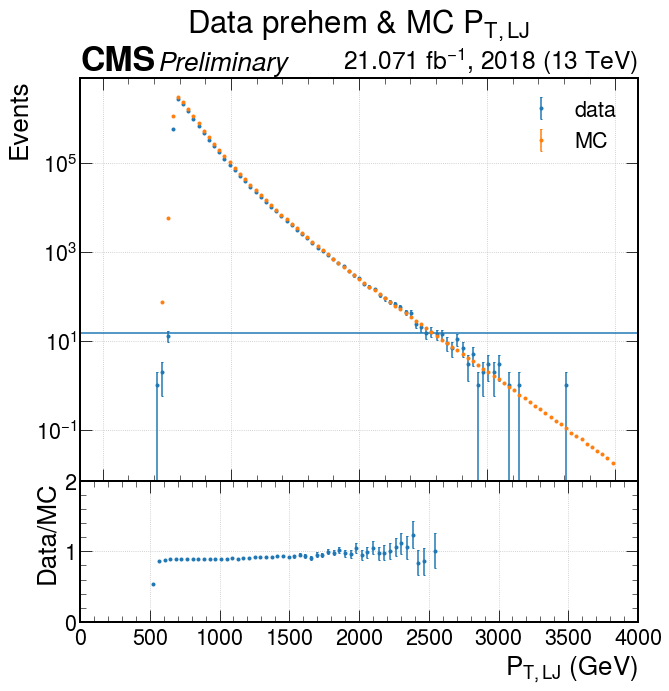

In [165]:
# define variables array
# MC each source array
qcd_lj_pt_values  = [qcd_bin[n]['lj_pt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_lj_pt_values  = [ttjet_bin[n]['lj_pt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_lj_pt_values  =  [wjet_bin[n]['lj_pt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_lj_pt_values  =  [zjet_bin[n]['lj_pt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_lj_pt_values  = [qcd_lj_pt_values , ttjet_lj_pt_values , wjet_lj_pt_values , zjet_lj_pt_values ]
# data variable array
data_lj_pt_values  =   [data_prehem[n]['lj_pt'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
lj_pt_bins = np.linspace(0, 4000, 100)
data_lj_pt_centre, data_lj_pt_stacked, data_edges_lj_pt = stacked_edge(data_lj_pt_values, lj_pt_bins, data_weight_arr, True)
data_lj_pt_err = np.sqrt(data_lj_pt_stacked)

mc_lj_pt_centre, mc_lj_pt_stacked, mc_edges_lj_pt = stacked_edge(mc_lj_pt_values, lj_pt_bins, mc_weights_arr, False)
mc_lj_pt_err = err(mc_lj_pt_values, lj_pt_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_lj_pt_centre, y=data_lj_pt_stacked, yerr=data_lj_pt_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_lj_pt_centre,   y=mc_lj_pt_stacked,   yerr=mc_lj_pt_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $P_{T,LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_lj_pt_stacked,
                  mc_lj_pt_stacked,
                  where=(mc_lj_pt_stacked != 0))
                  
rotio = ratio[(mc_lj_pt_stacked!=0) & (data_lj_pt_stacked>15)]
edges = data_edges_lj_pt[:len(data_edges_lj_pt)-1][(mc_lj_pt_stacked!=0) & (data_lj_pt_stacked>15)]
ratio_err = error_ratio(data_lj_pt_stacked, mc_lj_pt_stacked, np.sqrt(data_lj_pt_stacked), mc_lj_pt_err)
rotio_err = ratio_err[(mc_lj_pt_stacked!=0) & (data_lj_pt_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$P_{T,LJ}$ (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,4000)
fig.savefig('png/PTLJ_RatioPlot.png')

/tmp/ipykernel_29295/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

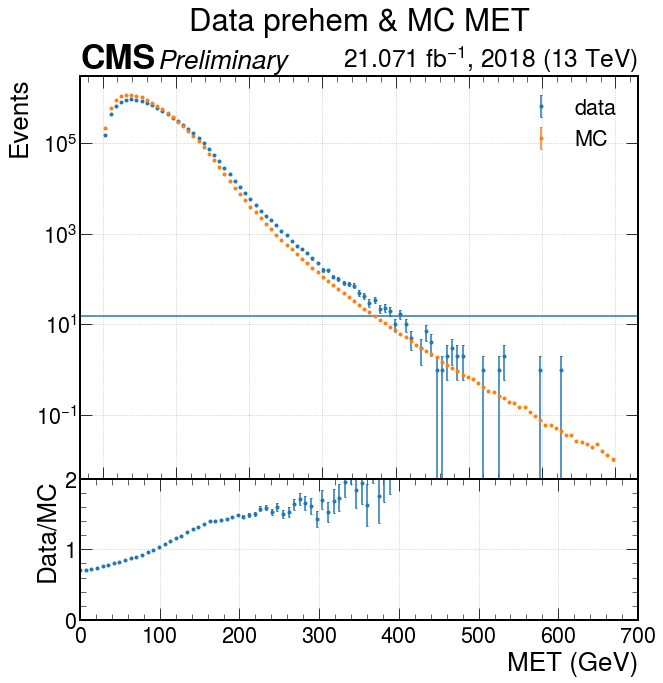

In [166]:
# define variables array
# MC each source array
qcd_met_values  = [qcd_bin[n]['met'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_met_values  = [ttjet_bin[n]['met'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_met_values  =  [wjet_bin[n]['met'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_met_values  =  [zjet_bin[n]['met'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_met_values  = [qcd_met_values , ttjet_met_values , wjet_met_values , zjet_met_values ]
# data variable array
data_met_values  =   [data_prehem[n]['met'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
met_bins = np.linspace(0, 700, 100)
data_met_centre, data_met_stacked, data_edges_met = stacked_edge(data_met_values, met_bins, data_weight_arr, True)
data_met_err = np.sqrt(data_met_stacked)

mc_met_centre, mc_met_stacked, mc_edges_met = stacked_edge(mc_met_values, met_bins, mc_weights_arr, False)
mc_met_err = err(mc_met_values, met_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_met_centre, y=data_met_stacked, yerr=data_met_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_met_centre,   y=mc_met_stacked,   yerr=mc_met_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC MET',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_met_stacked,
                  mc_met_stacked,
                  where=(mc_met_stacked != 0))
                  
rotio = ratio[(mc_met_stacked!=0) & (data_met_stacked>15)]
edges = data_edges_met[:len(data_edges_met)-1][(mc_met_stacked!=0) & (data_met_stacked>15)]
ratio_err = error_ratio(data_met_stacked, mc_met_stacked, np.sqrt(data_met_stacked), mc_met_err)
rotio_err = ratio_err[(mc_met_stacked!=0) & (data_met_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('MET (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,700)
fig.savefig('png/met_RatioPlot.png')

/tmp/ipykernel_22735/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

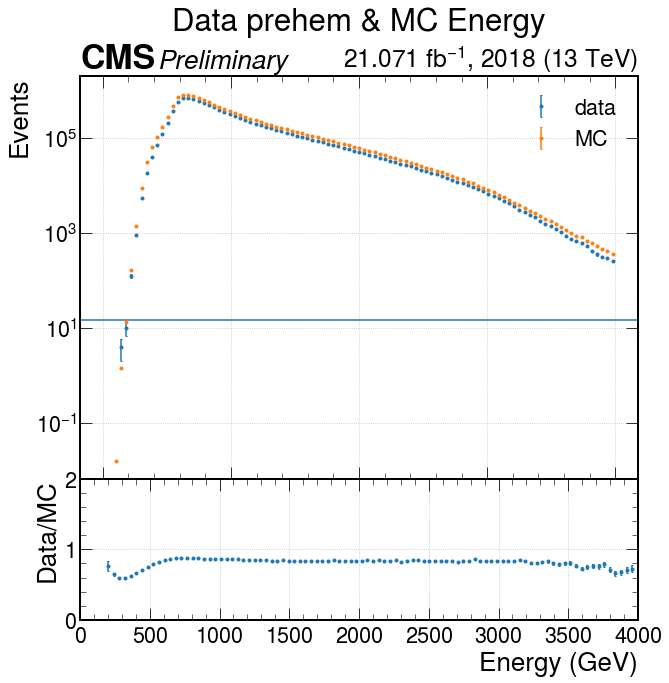

In [9]:
# define variables array
# MC each source array
qcd_energy_values  = [qcd_bin[n]['energy'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_energy_values  = [ttjet_bin[n]['energy'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_energy_values  =  [wjet_bin[n]['energy'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_energy_values  =  [zjet_bin[n]['energy'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_energy_values  = [qcd_energy_values , ttjet_energy_values , wjet_energy_values , zjet_energy_values ]
# data variable array
data_energy_values  =   [data_prehem[n]['energy'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
energy_bins = np.linspace(0, 4000, 100)
data_energy_centre, data_energy_stacked, data_edges_energy = stacked_edge(data_energy_values, energy_bins, data_weight_arr, True)
data_energy_err = np.sqrt(data_energy_stacked)

mc_energy_centre, mc_energy_stacked, mc_edges_energy = stacked_edge(mc_energy_values, energy_bins, mc_weights_arr, False)
mc_energy_err = err(mc_energy_values, energy_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_energy_centre, y=data_energy_stacked, yerr=data_energy_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_energy_centre,   y=mc_energy_stacked,   yerr=mc_energy_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC Energy',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_energy_stacked,
                  mc_energy_stacked,
                  where=(mc_energy_stacked != 0))
                  
rotio = ratio[(mc_energy_stacked!=0) & (data_energy_stacked>15)]
edges = data_edges_energy[:len(data_edges_energy)-1][(mc_energy_stacked!=0) & (data_energy_stacked>15)]
ratio_err = error_ratio(data_energy_stacked, mc_energy_stacked, np.sqrt(data_energy_stacked), mc_energy_err)
rotio_err = ratio_err[(mc_energy_stacked!=0) & (data_energy_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('Energy (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,4000)
fig.savefig('png/energy_RatioPlot.png')

/tmp/ipykernel_22735/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

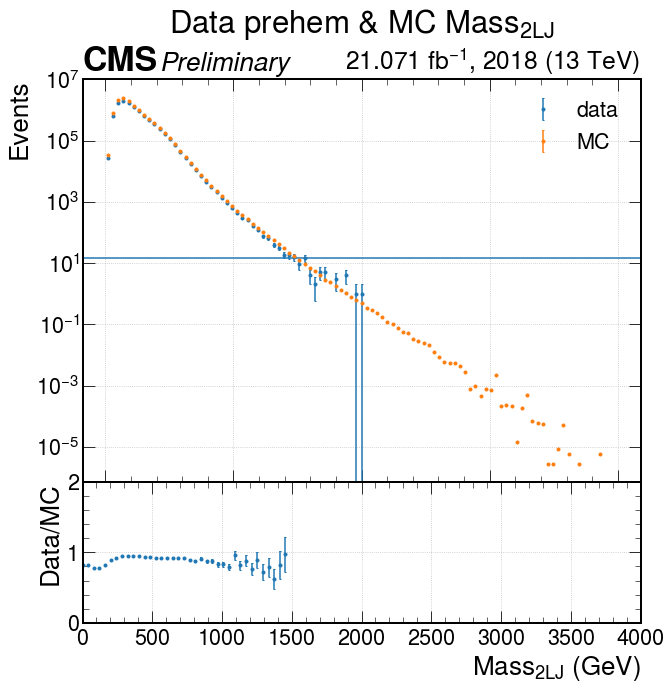

In [10]:
# define variables array
# MC each source array
qcd_mass_values  = [qcd_bin[n]['mass'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_mass_values  = [ttjet_bin[n]['mass'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_mass_values  =  [wjet_bin[n]['mass'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_mass_values  =  [zjet_bin[n]['mass'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_mass_values  = [qcd_mass_values , ttjet_mass_values , wjet_mass_values , zjet_mass_values ]
# data variable array
data_mass_values  =   [data_prehem[n]['mass'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
mass_bins = np.linspace(0, 4000, 100)
data_mass_centre, data_mass_stacked, data_edges_mass = stacked_edge(data_mass_values, mass_bins, data_weight_arr, True)
data_mass_err = np.sqrt(data_mass_stacked)

mc_mass_centre, mc_mass_stacked, mc_edges_mass = stacked_edge(mc_mass_values, mass_bins, mc_weights_arr, False)
mc_mass_err = err(mc_mass_values, mass_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_mass_centre, y=data_mass_stacked, yerr=data_mass_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_mass_centre,   y=mc_mass_stacked,   yerr=mc_mass_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $Mass_{2LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_mass_stacked,
                  mc_mass_stacked,
                  where=(mc_mass_stacked != 0))
                  
rotio = ratio[(mc_mass_stacked!=0) & (data_mass_stacked>15)]
edges = data_edges_mass[:len(data_edges_mass)-1][(mc_mass_stacked!=0) & (data_mass_stacked>15)]
ratio_err = error_ratio(data_mass_stacked, mc_mass_stacked, np.sqrt(data_mass_stacked), mc_mass_err)
rotio_err = ratio_err[(mc_mass_stacked!=0) & (data_mass_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$Mass_{2LJ}$ (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,4000)
fig.savefig('png/mass_RatioPlot.png')

/tmp/ipykernel_22735/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

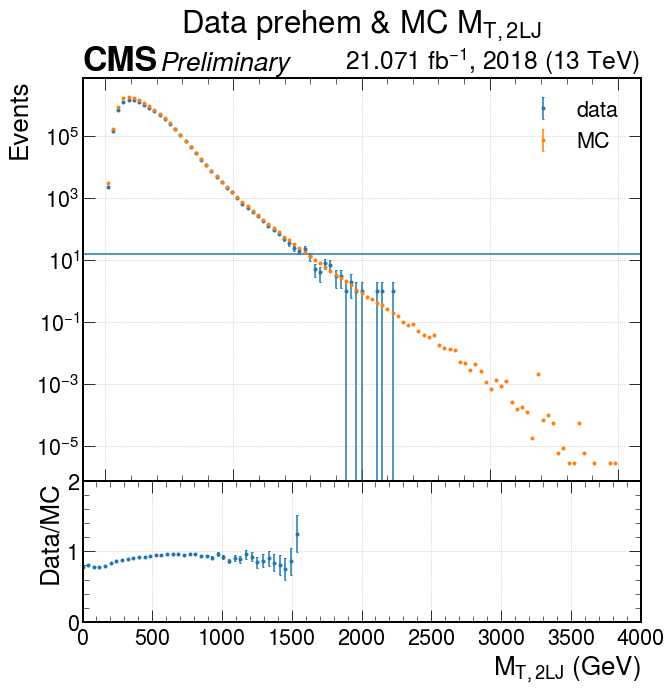

In [11]:
# define variables array
# MC each source array
qcd_mt_values  = [qcd_bin[n]['mt'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_mt_values  = [ttjet_bin[n]['mt'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_mt_values  =  [wjet_bin[n]['mt'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_mt_values  =  [zjet_bin[n]['mt'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_mt_values  = [qcd_mt_values , ttjet_mt_values , wjet_mt_values , zjet_mt_values ]
# data variable array
data_mt_values  =   [data_prehem[n]['mt'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
mt_bins = np.linspace(0, 4000, 100)
data_mt_centre, data_mt_stacked, data_edges_mt = stacked_edge(data_mt_values, mt_bins, data_weight_arr, True)
data_mt_err = np.sqrt(data_mt_stacked)

mc_mt_centre, mc_mt_stacked, mc_edges_mt = stacked_edge(mc_mt_values, mt_bins, mc_weights_arr, False)
mc_mt_err = err(mc_mt_values, mt_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_mt_centre, y=data_mt_stacked, yerr=data_mt_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_mt_centre,   y=mc_mt_stacked,   yerr=mc_mt_err,   fmt='.', capsize=1, label='MC')
ax1.axhline(y=15)
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $M_{T,2LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_mt_stacked,
                  mc_mt_stacked,
                  where=(mc_mt_stacked != 0))
                  
rotio = ratio[(mc_mt_stacked!=0) & (data_mt_stacked>15)]
edges = data_edges_mt[:len(data_edges_mt)-1][(mc_mt_stacked!=0) & (data_mt_stacked>15)]
ratio_err = error_ratio(data_mt_stacked, mc_mt_stacked, np.sqrt(data_mt_stacked), mc_mt_err)
rotio_err = ratio_err[(mc_mt_stacked!=0) & (data_mt_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$M_{T,2LJ}$ (GeV)')
ax2.set_ylabel('Data/MC')
ax2.set_xlim(0,4000)
fig.savefig('png/mt_RatioPlot.png')

/tmp/ipykernel_29295/3817820698.py:18: RuntimeWarning: invalid value encountered in true_divide
  dA = np.sqrt((err_data/data)**2 + (err_mc/mc)**2)*data/mc


<Figure size 720x360 with 0 Axes>

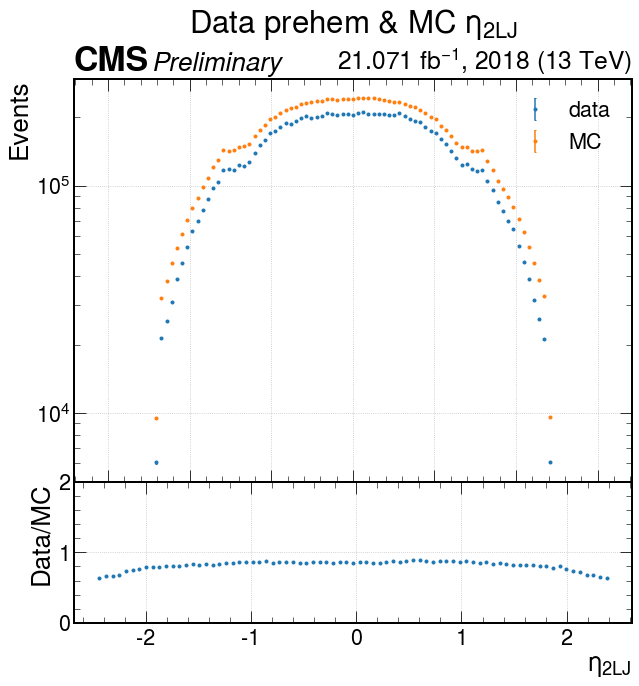

In [174]:
# define variables array
# MC each source array
qcd_eta_values  = [qcd_bin[n]['eta'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_eta_values  = [ttjet_bin[n]['eta'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_eta_values  =  [wjet_bin[n]['eta'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_eta_values  =  [zjet_bin[n]['eta'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_eta_values  = [qcd_eta_values , ttjet_eta_values , wjet_eta_values , zjet_eta_values ]
# data variable array
data_eta_values  =   [data_prehem[n]['eta'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
eta_bins = np.linspace(-3.14, 3.14, 100)
data_eta_centre, data_eta_stacked, data_edges_eta = stacked_edge(data_eta_values, eta_bins, data_weight_arr, True)
data_eta_err = np.sqrt(data_eta_stacked)

mc_eta_centre, mc_eta_stacked, mc_edges_eta = stacked_edge(mc_eta_values, eta_bins, mc_weights_arr, False)
mc_eta_err = err(mc_eta_values, eta_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_eta_centre, y=data_eta_stacked, yerr=data_eta_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_eta_centre,   y=mc_eta_stacked,   yerr=mc_eta_err,   fmt='.', capsize=1, label='MC')
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $\eta_{2LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_eta_stacked,
                  mc_eta_stacked,
                  where=(mc_eta_stacked != 0))
                  
rotio = ratio[(mc_eta_stacked!=0) & (data_eta_stacked>15)]
edges = data_edges_eta[:len(data_edges_eta)-1][(mc_eta_stacked!=0) & (data_eta_stacked>15)]
ratio_err = error_ratio(data_eta_stacked, mc_eta_stacked, np.sqrt(data_eta_stacked), mc_eta_err)
rotio_err = ratio_err[(mc_eta_stacked!=0) & (data_eta_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$\eta_{2LJ}$')
ax2.set_ylabel('Data/MC')
fig.savefig('png/eta_RatioPlot.png')

<Figure size 720x360 with 0 Axes>

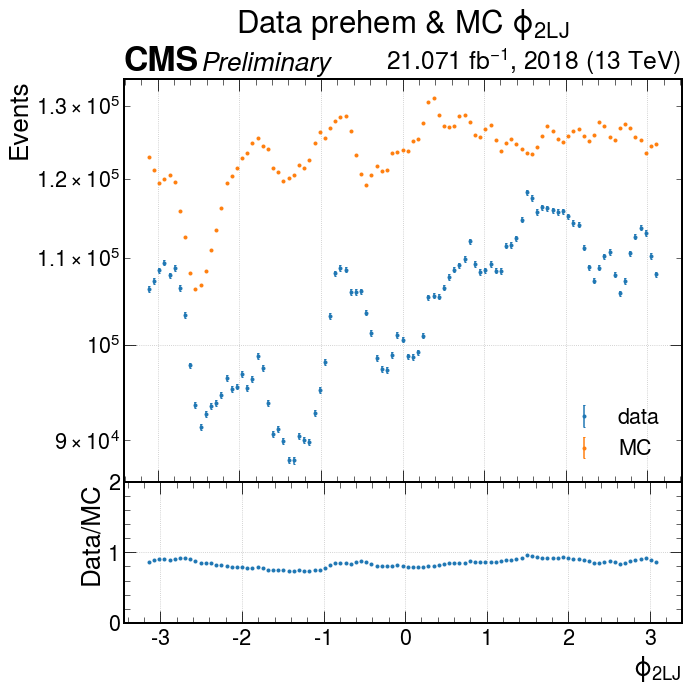

In [175]:
# define variables array
# MC each source array
qcd_phi_values  = [qcd_bin[n]['phi'][(qcd_bin[n]['n_electrons']==0) & (qcd_bin[n]['n_muons']==0)] for n in range(0,9)]
ttjet_phi_values  = [ttjet_bin[n]['phi'][(ttjet_bin[n]['n_electrons']==0) & (ttjet_bin[n]['n_muons']==0)] for n in range(0,8)]
wjet_phi_values  =  [wjet_bin[n]['phi'][(wjet_bin[n]['n_electrons']==0) & (wjet_bin[n]['n_muons']==0)] for n in range(0,5)]
zjet_phi_values  =  [zjet_bin[n]['phi'][(zjet_bin[n]['n_electrons']==0) & (zjet_bin[n]['n_muons']==0)] for n in range(0,5)]
# MC combine sources in one multi-dim array
mc_phi_values  = [qcd_phi_values , ttjet_phi_values , wjet_phi_values , zjet_phi_values ]
# data variable array
data_phi_values  =   [data_prehem[n]['phi'][(data_prehem[n]['n_electrons']==0) & (data_prehem[n]['n_muons']==0)] for n in range(0,2)]

#derive elements of ratio plot
phi_bins = np.linspace(-3.14, 3.14, 100)
data_phi_centre, data_phi_stacked, data_edges_phi = stacked_edge(data_phi_values, phi_bins, data_weight_arr, True)
data_phi_err = np.sqrt(data_phi_stacked)

mc_phi_centre, mc_phi_stacked, mc_edges_phi = stacked_edge(mc_phi_values, phi_bins, mc_weights_arr, False)
mc_phi_err = err(mc_phi_values, phi_bins, mc_weights_arr)


#MC & data [lots]
fig = plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 7]})
plt.subplots_adjust(wspace=0, hspace=0)
hep.cms.label('Preliminary', data=True, loc=0, lumi=21.071, year=2018, ax=ax1)
hep.style.use("CMS")


ax1.errorbar(x=data_phi_centre, y=data_phi_stacked, yerr=data_phi_err, fmt='.', capsize=1, label='data')
ax1.errorbar(x=mc_phi_centre,   y=mc_phi_stacked,   yerr=mc_phi_err,   fmt='.', capsize=1, label='MC')
ax1.legend()
ax1.grid('True')
ax1.set_title('Data prehem & MC $\phi_{2LJ}$',y=1.1)
ax1.set_yscale('log')
ax1.set_ylabel('Events')

# Data/MC ratio plot
ratio = np.divide(data_phi_stacked,
                  mc_phi_stacked,
                  where=(mc_phi_stacked != 0))
                  
rotio = ratio[(mc_phi_stacked!=0) & (data_phi_stacked>15)]
edges = data_edges_phi[:len(data_edges_phi)-1][(mc_phi_stacked!=0) & (data_phi_stacked>15)]
ratio_err = error_ratio(data_phi_stacked, mc_phi_stacked, np.sqrt(data_phi_stacked), mc_phi_err)
rotio_err = ratio_err[(mc_phi_stacked!=0) & (data_phi_stacked>15)]


ax2.errorbar(x=edges, y=rotio, yerr=rotio_err, fmt='.', capsize=1)
ax2.set_ylim(0,2)
ax2.grid('True')
ax2.set_xlabel('$\phi_{2LJ}$')
ax2.set_ylabel('Data/MC')
fig.savefig('png/phi_RatioPlot.png')